# More on monitors and stimulus

**EBRAINS & IBRO First Virtual Master Class on Brain Atlasing and Simulation Services, July 29, 2021**

# Objectives

Here we:
* introduce stimulus
* explore the BOLD monitor

Let's import the modules we need.

In [4]:
%%capture

import os

import numpy as np
import matplotlib.pylab as plt

from tvb.simulator.lab import *

Next we create a connectivity to set the spatial context for our stimulation.

In [5]:
conn = connectivity.Connectivity.from_file( os.path.abspath('dataset/connectivity_76.zip'))
conn.configure()

With that at hand, we can start with defining the spatial profile of the stimulus. Here as a vector of weights of the length of number of regions.

In [6]:
# configure stimulus spatial pattern
weighting = np.zeros((conn.number_of_regions, ))
weighting[[0, 7, 13, 33, 42]] = np.array([2.0 ** -2, 2.0 ** -3, 2.0 ** -4, 2.0 ** -5, 2.0 ** -6])

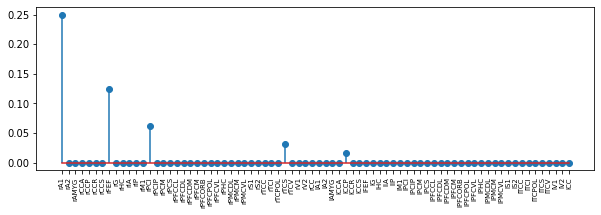

In [7]:
plt.figure(figsize=(10,3))
plt.stem(weighting, use_line_collection=True)
plt.xticks(range(0, conn.number_of_regions), conn.region_labels, fontsize=7, rotation=90);

Second, we define the temporal profile. In TVB, this is achieved parametrically to allow for flexibility in other components (e.g. independence on `dt` of the integration).

In [8]:
# temporal profile
eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 25000.0 # ms
eqn_t.parameters["sigma"] = 200.0 # ms
eqn_t

,value
Equation type,Gaussian
equation,(amp * exp(-((var-midpoint)**2 / (2.0 * sigma**2))))+offset
parameters,"{'amp': 1.0, 'sigma': 200.0, 'midpoint': 25000.0, 'offset': 0.0}"


Putting these two together gives us the stimulus object:

In [9]:
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=conn,
                                  weight=weighting)

In [10]:
stimulus

,value
Spatial equation,DiscreteEquation
Spatial parameters,{}
Temporal equation,Gaussian
Temporal parameters,"{'amp': 1.0, 'sigma': 200.0, 'midpoint': 25000.0, 'offset': 0.0}"
Type,StimuliRegion


Now let's take a short look at the BOLD monitor. TVB implements several variants differing in the HRF kernels. The default is the `FirstOrderVolterra`. Let's use this opportunity to demonstrate how to get moew information on the TVB components.

Let's say we want to know what HRF other kernels are available in TVB. First we take a look at the BOLD monitor, and look for the `hrf_kernel` attribute:

In [11]:
monitors.Bold?

Init signature: monitors.Bold(**kwargs)
Docstring:     
Traited class [tvb.simulator.monitors.Bold]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



    Base class for the Bold monitor.

    **Attributes**

        hrf_kernel: the haemodynamic response function (HRF) used to compute
                    the BOLD (Blood Oxygenation Level Dependent) signal.

        length    : duration of the hrf in seconds.

        period    : the monitor's period

    **References**:

    .. [B_1997] Buxton, R. and Frank, L., *A Model for the Coupling between
        Cerebral Blood Flow and Oxygen Metabolism During Neural Stimulation*,
        17:64-72, 1997.

    .. [Fr_2000] Friston, K., Mechelli, A., Turner, R., and Price, C., *Nonlinear
        Responses in fMRI: The Balloon Model, Volterra Kernels, and Other
        Hemodynamics*, NeuroImage, 12, 466 - 477, 2000.

    .. [Bo_1996] Geoffrey M. Boynton, Stephen A. Engel, Gary H. Glover and David
        J. Heeger (1996). Linear Systems Analysis of Fu

It says it's type is `tvb.datatypes.equations.HRFKernelEquation`, let's take a look what that is:

In [12]:
equations.HRFKernelEquation?

Init signature: equations.HRFKernelEquation(**kwargs)
Docstring:     
Traited class [tvb.datatypes.equations.HRFKernelEquation]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Base class for hemodynamic response functions.

Attributes declared
"""""""""""""""""""

equation : tvb.datatypes.equations.Equation.equation = Attr(field_type=<class 'str'>, default=None, required=True)
    the equation as it should be interpreted by numexpr

parameters : tvb.datatypes.equations.Equation.parameters = Attr(field_type=<class 'dict'>, default=<function Equation.<lambda> at 0x7f68f368c488>, required=True)
    Should be a list of the parameters and their meaning, Traits
    should be able to take defaults and sensible ranges from any
    traited information that was provided.

gid : tvb.basic.neotraits._core.HasTraits.gid = Attr(field_type=<class 'uuid.UUID'>, default=None, required=True)
Init docstring:
The default init accepts kwargs for all declarative attrs
and sets them to the given v

Ok, so we see that the available variants (*subclasses*) are `Gamma`, `DoubleExponential`, `FirstOrderVolterra`, `MixtureOfGammas`. Let's take a look at the last one:

In [13]:
equations.Gamma?

Init signature: equations.Gamma(**kwargs)
Docstring:     
Traited class [tvb.datatypes.equations.Gamma]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


    A Gamma function for the bold monitor. It belongs to the family of Exponential functions.

    **Parameters**:


    * :math:`\tau`      : Exponential time constant of the gamma function [seconds].
    * :math:`n`          : The phase delay of the gamma function.
    * :math: `factorial` : (n-1)!. numexpr does not support factorial yet.
    * :math: `a`         : Amplitude factor after normalization.


    **Reference**:

    .. [B_1996] Geoffrey M. Boynton, Stephen A. Engel, Gary H. Glover and David
        J. Heeger (1996). Linear Systems Analysis of Functional Magnetic Resonance
        Imaging in Human V1. J Neurosci 16: 4207-4221

    .. note:: might be filtered from the equations used in Stimulus and Local Connectivity.

    

Attributes declared
"""""""""""""""""""

equation : tvb.datatypes.equations.Gamma.equation = Final(fi

Let's take it for a spin. Contrary to the previous example, we will define the `Simulator` in more concise manner.

In [11]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=np.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=np.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500),
        monitors.ProgressLogger(period=5e3),
    ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

With the time configured through the simulator, we can now plot the summary of the stimulus to double check we stimulated at the correct time and space.

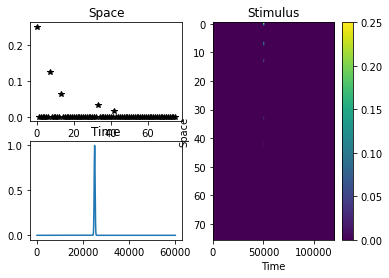

In [12]:
plot_pattern(sim.stimulus)

If we zoom in and add the temporal average and BOLD time series, we can observe the instant response of the system to the stimulus, and the delayed BOLD peak.

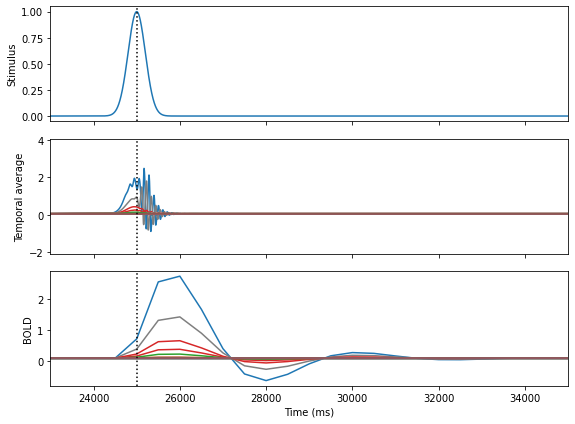

In [13]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(8,6))

t0=23000 # ms
t1=35000 # ms

ax = axs[0]
ax.plot(sim.stimulus.time[0,], sim.stimulus.temporal_pattern[0])
ax.set(ylabel="Stimulus")

ax = axs[1]
ax.plot(tavg_time, tavg_data[:, 0, :, 0])
ax.set(ylabel="Temporal average")

ax = axs[2]
ax.plot(bold_time, bold_data[:, 0, :, 0])
ax.set(ylabel="BOLD", xlabel='Time (ms)', xlim=[t0,t1])


for ax in axs:
    ax.axvline(x=25000, c='k', ls=':')

fig.tight_layout()

Let's compare it to the alternative HRF: `Gamma`.

In [14]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=np.array([0.5])),
    connectivity=conn,
    coupling=coupling.Linear(a=np.array([0.0126])),
    integrator=integrators.HeunDeterministic(dt=0.5),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500, hrf_kernel=equations.Gamma()),
        monitors.ProgressLogger(period=5e3),
    ),
    stimulus=stimulus,
    simulation_length=60e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

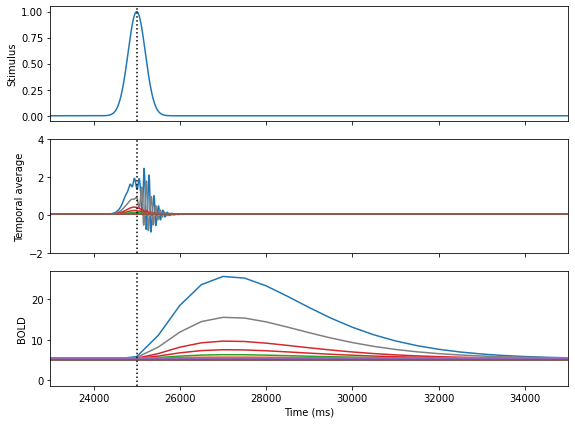

In [15]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(8,6))

t0=23000 # ms
t1=35000 # ms

ax = axs[0]
ax.plot(sim.stimulus.time[0,], sim.stimulus.temporal_pattern[0])
ax.set(ylabel="Stimulus")

ax = axs[1]
ax.plot(tavg_time, tavg_data[:, 0, :, 0])
ax.set(ylabel="Temporal average")

ax = axs[2]
ax.plot(bold_time, bold_data[:, 0, :, 0])
ax.set(ylabel="BOLD", xlabel='Time (ms)', xlim=[t0,t1])


for ax in axs:
    ax.axvline(x=25000, c='k', ls=':')

fig.tight_layout()

Note: Such controlled experimentation is useful when trying to understand how are the particular components contributing to the final result.

Alternatively, we can also inspect the HRF kernels directly (see the [Exploring The Bold Monitor demo](https://nbviewer.thevirtualbrain.org/url/docs.thevirtualbrain.org/demos/exploring_the_bold_monitor.ipynb)).

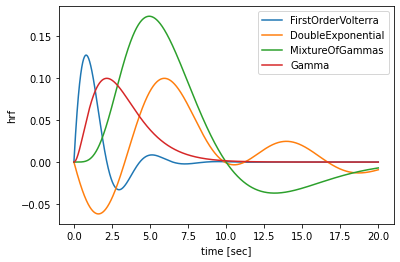

In [16]:
hrf_kernels = [equations.FirstOrderVolterra(),
               equations.DoubleExponential(),
               equations.MixtureOfGammas(),
               equations.Gamma()]

plt.figure()
for hrf in hrf_kernels: 
    bold_monitor = monitors.Bold(hrf_kernel=hrf)
    bold_monitor.dt = 2**-4
    bold_monitor.compute_hrf()
    plt.plot(bold_monitor._stock_time,
         bold_monitor.hemodynamic_response_function.T[::-1], 
         label=hrf.__class__.__name__);

plt.ylabel('hrf');
plt.xlabel('time [sec]')    
plt.legend()

# What is next?

* getting data from EBRAINS
* epilepsy use case